In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0,'../../modules')

In [99]:
import numpy as np
import factors
import pgm_sampling
import common_plots
from math import gamma

# Bayesian Parameter Learning
The bayesian approach to parameter learning is to obtain a distribution over $\theta$ given the data $X$, called the posterior. That posterior is then used to make predictions. To do so you can use the maximum posterior value of $\theta$ or better yet integrate out $\theta$ entirely:

### Integrating out the model (Derivation)
Much of machine learning concerns generating preditions based on past data. We want to know $P(X_\text{new}|X_\text{old})$. <br>
But in order to generate good predictions it is necessary to have a model with parameters $\theta$. The above can be rewritten
$$P(X_\text{new}|X_\text{old})=\int P(X_\text{new},\theta|X_\text{old}) d\theta$$
Which can in turn be expanded with the product rule: <br>
$$P(X_\text{new}|X_\text{old})=\int P(X_\text{new}|\theta,X_\text{old})P(\theta|X_\text{old}) d\theta$$
Making the assumption that the model encodes the previous data this becomes:
$$P(X_\text{new}|X_\text{old})=\int P(X_\text{new}|\theta)P(\theta|X_\text{old}) d\theta$$
This formula represents the purest way to predict data with a parameter based model. The parameters of the model are integrated out over all possible values, where the probability of each prediction is weighed by the model probability. For instance, consider that there are two coins ($C_1$ and $C_2$), one of which is selected and used in a single flip. $C_1$ has heads on both sides and from previous data has a $10\%$ chance of being selected. $C_2$ is fair and has a $90\%$ chance of being selected. The correct way to predict new data is to apply the above formula. Say you want to know the probability of heads ($H$). That is given by the above formula as: $p(H)=1\times0.1 + 0.5\times0.9=0.55$. This is easy to verify with sampling:

In [3]:
total_heads = 0
total = 0
for sample in range(10000):
    coin = np.random.choice(["C1","C2"],p=[0.1,0.9])
    if(coin=="C1"):
        total_heads+=1
        total+=1
    if(coin=="C2"):
        if(np.random.rand()>=0.5):
            total_heads+=1
        total+=1
prob_heads_estimates = total_heads/total
print("estimate",prob_heads_estimates)

estimate 0.5549


### MAP estimates
A more tractable alternative is to use the maximum value of the distribution over $\theta$ to make predicitons. 
$$P(X_\text{new}|X_\text{old})=P(X_\text{new}|\theta)$$
where $$\theta = \text{argmax}_\theta P(\theta|X_\text{old})$$

# Examples

### The Beta-Binomial Model
#### Full Integration Approach
Consider a coin with a single bentness, $\theta$. For $k$ heads out of $n$ trials the likelihood is:
$$P(k|n,\theta)=\frac{\theta^k (1-\theta)^{n-k}n!}{k!(n-k)!}$$
Ideally, we would like a distribution over $\theta$, so using bayes rule:
$$P(\theta|k,n)=\frac{P(k|n,\theta)P(n,\theta)}{P(k,n)}$$
As $P(n)=1$ this simplifies:
$$P(\theta|k,n)=\frac{P(k|n,\theta)P(\theta)}{P(k,n)}$$
where $N$ is the normalization. Substituting in the formula (and replacing the normalization with $m$):
$$P(\theta|k,n)=m\theta^k (1-\theta)^{n-k}P(\theta)$$
The beta model is defined for pseduo-counts $\alpha$ and $\beta$: 
$$\frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}{B(\alpha,\beta)}$$
Where $B(\alpha,\beta)$ = $\frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha+\beta)}$ <br>
And the function $\Gamma(j)=(j-1)!$ <br>
The posterior is:
$$P(\theta|k,n)=m\theta^k (1-\theta)^{n-k}\frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}{B(\alpha,\beta)}$$
Collecting the terms this becomes:
$$P(\theta|k,n)=\frac{m}{B(\alpha,\beta)} \theta^{k+\alpha-1} (1-\theta)^{n-k+\beta-1}$$
Which is the exact formula for a beta distribution with parameters: <br>
$\alpha'=k+\alpha$, $\beta'=n-k+\beta$ <br>
This means the normalization $\frac{m}{B(\alpha,\beta)}$ is just $B(\alpha',\beta')$.
The prior is a conjugate prior as it takes the same form as the posterior. <br>
**Example:**

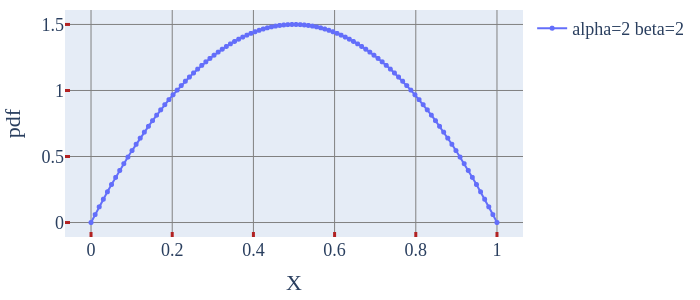

In [4]:
true_bentness = 0.6
# prior which thinks the coin is more likely to be fair
prior_alpha = 2
prior_beta = 2
fig = common_plots.plot_beta_model(prior_alpha,prior_beta)
fig.show(renderer="png",width=700,height=300)

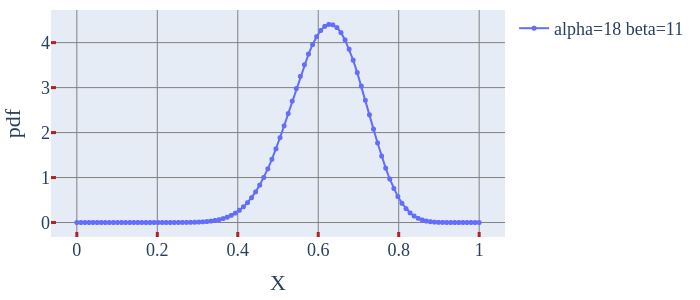

In [5]:
# get posterior
heads = 0
flips = 0
for sample in range(25):
    flip = np.random.choice(["H","T"],p=[true_bentness,1-true_bentness])
    if(flip=="H"):
        heads+=1
    flips+=1
posterior_alpha = prior_alpha+heads
posterior_beta = prior_beta+(flips-heads)
fig = common_plots.plot_beta_model(posterior_alpha,posterior_beta)
fig.show(renderer="png",width=700,height=300)

At this point to make a prediction (e.g the probability of heads), we apply the formula:
$$P(H|X_\text{old})=\int P(X_\text{new}|\theta)P(\theta|X_\text{old}) d\theta$$
Which in this case is:
$$P(H|X_\text{old})=\int \theta \frac{\theta^{\alpha'-1}(1-\theta)^{\beta'-1}}{B(\alpha',\beta')} d\theta$$
Which becomes:
$$P(H|X_\text{old})=\int \frac{\theta^{\alpha'}(1-\theta)^{\beta'-1}}{B(\alpha',\beta')} d\theta$$
The constant can be pulled out:
$$P(H|X_\text{old})=\frac{1}{B(\alpha',\beta')} \int\theta^{\alpha'}(1-\theta)^{\beta'-1} d\theta$$
By definition:
$$P(H|X_\text{old})=\frac{1}{B(\alpha',\beta')} B(\alpha'+1,\beta')$$
Which becomes (with some simple substitution):
$$P(H|X_\text{old})=\frac{\Gamma(\alpha'+1)}{\Gamma(\alpha')}\frac{\Gamma(\alpha'+\beta')}{\Gamma(\alpha'+\beta'+1)}$$
$$P(H|X_\text{old})=\frac{\alpha'!}{(\alpha'-1)!}\frac{(\alpha'+\beta'-1)!}{(\alpha'+\beta')!}$$
Which is:
$$P(H|X_\text{old})=\frac{\alpha'}{\alpha'+\beta'}$$

In [6]:
int_prob_heads = posterior_alpha/(posterior_alpha+posterior_beta)
print("INTEGRATION P(H)=",round(int_prob_heads,4))

INTEGRATION P(H)= 0.6207


#### MAP approach
The alternative is to use the maximum value in the posterior, as for MLE estimation:
$$
\begin{aligned}
    \theta &= \text{argmax}_\theta P(\theta|X_\text{old}) \\
    &= \text{argmax}_\theta \theta^{\alpha'-1}(1-\theta)^{\beta'-1}
\end{aligned}
$$
Setting the gradient to 0 (as in MLE estimation):
$$\theta = \frac{\alpha'-1}{\alpha'-1+\beta'-1}$$

In [7]:
MAP_theta = (posterior_alpha-1)/(posterior_alpha+posterior_beta-2)
MAP_probability_heads = MAP_theta
print("MAP P(H)=",round(MAP_probability_heads,4))

MAP P(H)= 0.6296


The MAP estimate is the mode of the beta distribution and the integration estimate is the mean.

### Dirichlet-Multinomial model
The extension of the beta model for more than 2 variables is called the Dirichlet model. For $n$ variables the distribution parameters are $\theta_{1:n}$. The pseudo counts are $\alpha_{1:n}$. The density is:
$$p(\theta_{1:n}|\alpha_{1:n})=\frac{\Gamma(\sum_{i=1}^n \alpha_i)}{\prod_{i=1}^n\Gamma (\alpha_i))}\prod_{i=1}^n \theta_i^{\alpha_i-1}$$
**Some Examples**

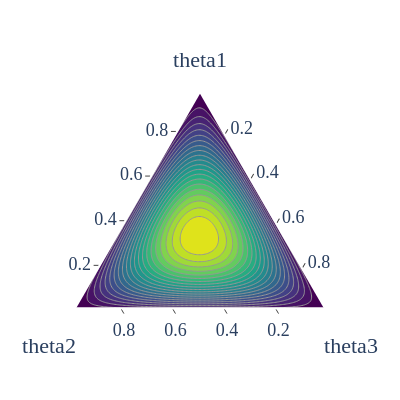

In [179]:
fig222 = common_plots.plot_3D_dirichlet(np.array([2,2,2]))
fig222.show(renderer="png",width=400,height=400)

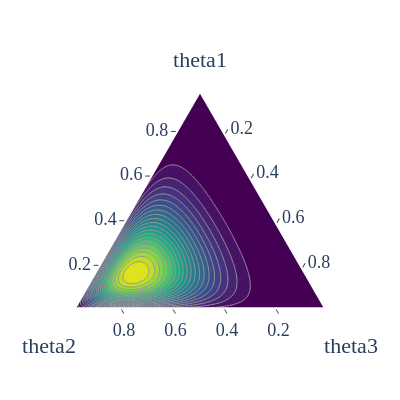

In [178]:
fig252 = common_plots.plot_3D_dirichlet(np.array([2,5,2]))
fig252.show(renderer="png",width=400,height=400)

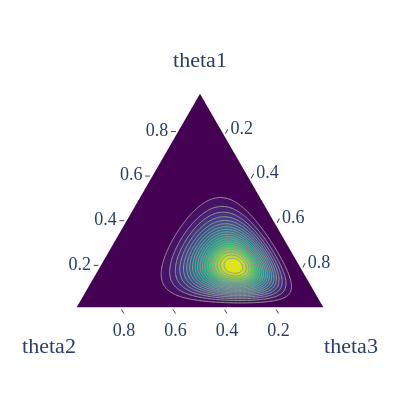

In [183]:
fig459 = common_plots.plot_3D_dirichlet(np.array([4,5,9]))
fig459.show(renderer="png",width=400,height=400)